# Data Profiling

## Prerequisites

- aws credentials file correctly configured on your local machine with enough permissions to read the csv file from s3
- python 3.8-3.9 virtual environment installed and activated (will be used for this notebook)
- python requirements installed (run step below only once)

In [ ]:
# Run only once
%pip install ydata-profiling==4.16.1
%pip install boto3==1.26.106

## Considerations

- CSV sample file was uploaded to AWS S3 as it is (data & structure, filename was renamed), maintaining data privacy in a secure cloud environment.
- The following script could be simpler if profiling is done on a local file instead of the aws cloud.
- I'm using a python library called [ydata_profiling](https://github.com/ydataai/ydata-profiling) that is free and very powerful for exploratory data analysis, with just a few lines of code, you can perform a complete profiling report of an entire dataset in considerable detail, which minimizes development effort and facilitates faster delivery of results.
- I could have used PowerBI/Tableau/Python plotting to perform an exploratory analysis, but it requires more time, which is a limitation at this time.

In [ ]:
import boto3
import pandas as pd
import logging
from io import StringIO
from ydata_profiling import ProfileReport

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    force=True # Only in jupyter notebooks
)
logger = logging.getLogger(__name__)

aws_region = 'us-east-1'
s3_bucket_name = 'novi-raw-dev'
s3_key = 'data/bank_loans_20250820.csv'
report_path = "data_profiling_report.html"

def s3_read_csv(bucket_name, key, aws_region):
    try:
        s3_client = boto3.client("s3", region_name=aws_region)

        logger.info(f"Reading file '{key}' from bucket '{bucket_name}'...")

        response = s3_client.get_object(Bucket=bucket_name, Key=key)

        csv_content = response["Body"].read().decode("utf-8")
        df = pd.read_csv(StringIO(csv_content), sep=',', header=0, encoding='utf-8')

        logger.info("File was read successfully")
        return df
    except Exception as e:
        logger.error(f"ERROR: {e}")
        raise

df = s3_read_csv(s3_bucket_name, s3_key, aws_region)
logger.info("Generating profiling report...")
profile = ProfileReport(df, title="Novicap Profiling Report")
profile.to_file(report_path)
logger.info(f"Report was exported as html in {report_path}")

/home/svargasg/de_novicap_test/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-08-18 21:26:58,914 [INFO] Found credentials in shared credentials file: ~/.aws/credentials
2025-08-18 21:26:59,096 [INFO] Reading file 'de_sample.csv' from bucket 'novi-raw-dev'...
2025-08-18 21:27:01,531 [INFO] File was read successfully
2025-08-18 21:27:01,534 [INFO] Generating profiling report...
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 84.57it/s]
2025-08-18 21:27:41,612 [INFO] Report was exported as html in data_profiling_report.html


Please download and open in web browser the [data_profiling_report.html](./data_profiling_report.html) that was created in the **eda** folder. That report contains all the relevant info for data profiling that i'm going to explain in detail below.

## Advanced feature

If new files (or existing ones) are received for profiling and automated work is required, a dag named [data_profiling.py](../dags/data_profiling.py) was created in Airflow that reuses the previous logic to complete the following workflow:
 
* read file from s3 -> convert csv data to dataframe -> generate profiling report -> upload report to the cloud

Based on the previous, an analyst could simply execute a dag to generate a data profiling report in cloud and analyze it.

#### Requirements

- Launch Airflow using the current repository as base for airflow instance - [Run Airflow Locally](https://www.astronomer.io/docs/astro/cli/local-airflow-overview)
    - Airflow with astronomer distribution was used because is easy to deploy in local environment. This could be deployed in a AWS EC2 instance or Astronomer Cloud.
    - Airflow using MWAA is not an option due high costs, Using MWAA is not justified to solve a recruitment challenge. Airflow deployed in K8s is complex to implement and time is a limitation.
- Create the connection to aws called "aws_conn" using aws creds under "Admin" -> "Connections" in Airflow Webserver
- CSV files must exist in S3 in a specific raw bucket.
- Set correctly the values for environment variables [dev.env](../envs/dev.env)

### Example of use

1. Ensure CSV file exists in s3 (or upload it)

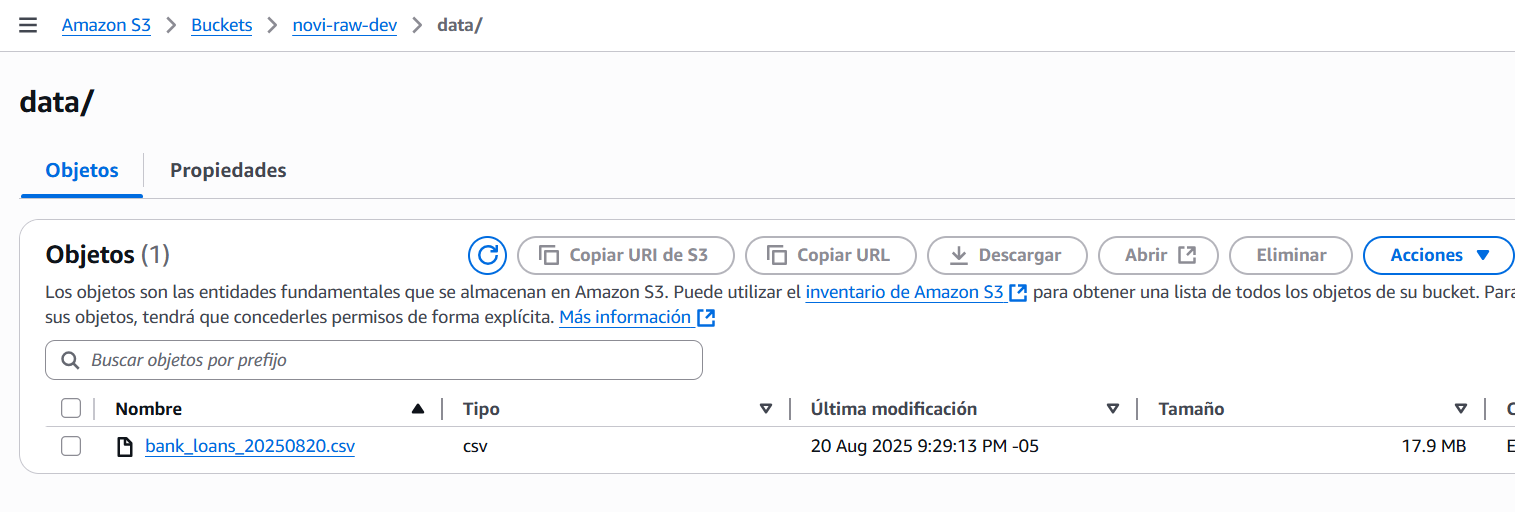

2. Airflow dag execution (set a config parameter called s3_key with the name of the csv file that was stored in s3), wait until dag finishes

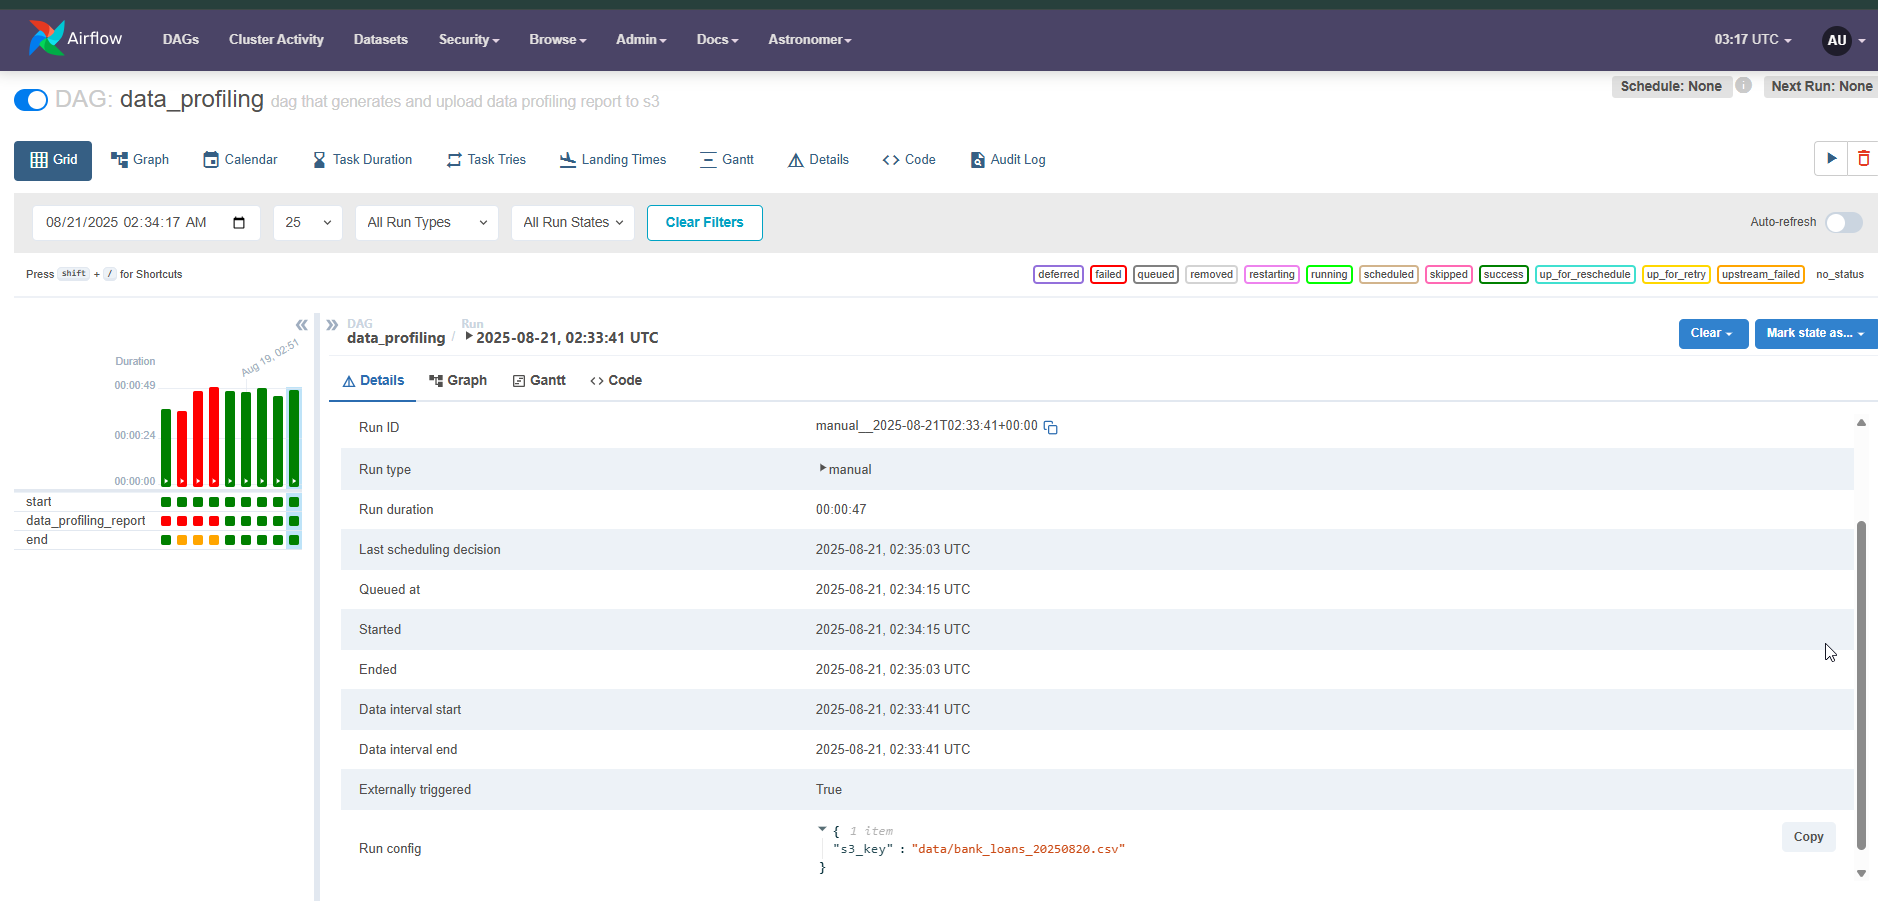

3. Check that profiling report in s3 was created

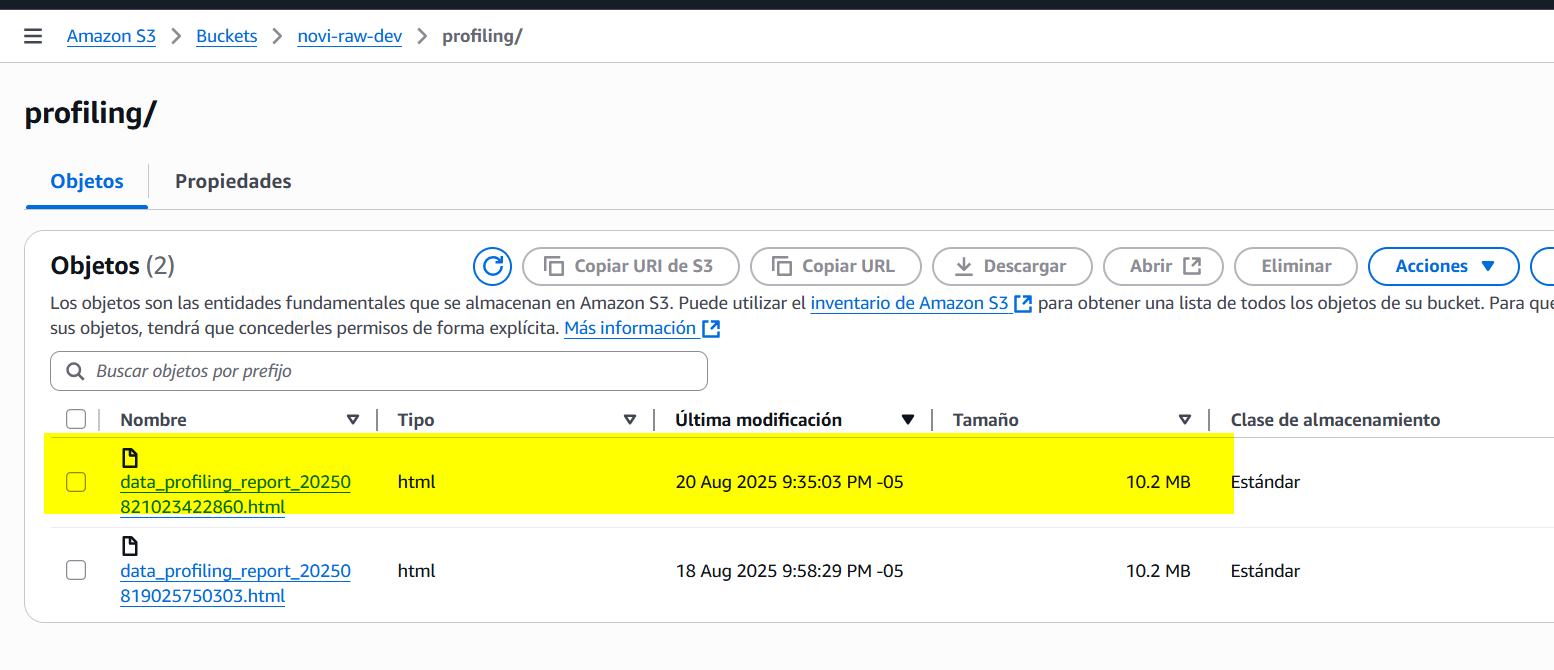

4. Open the html report, browse and interact with it.

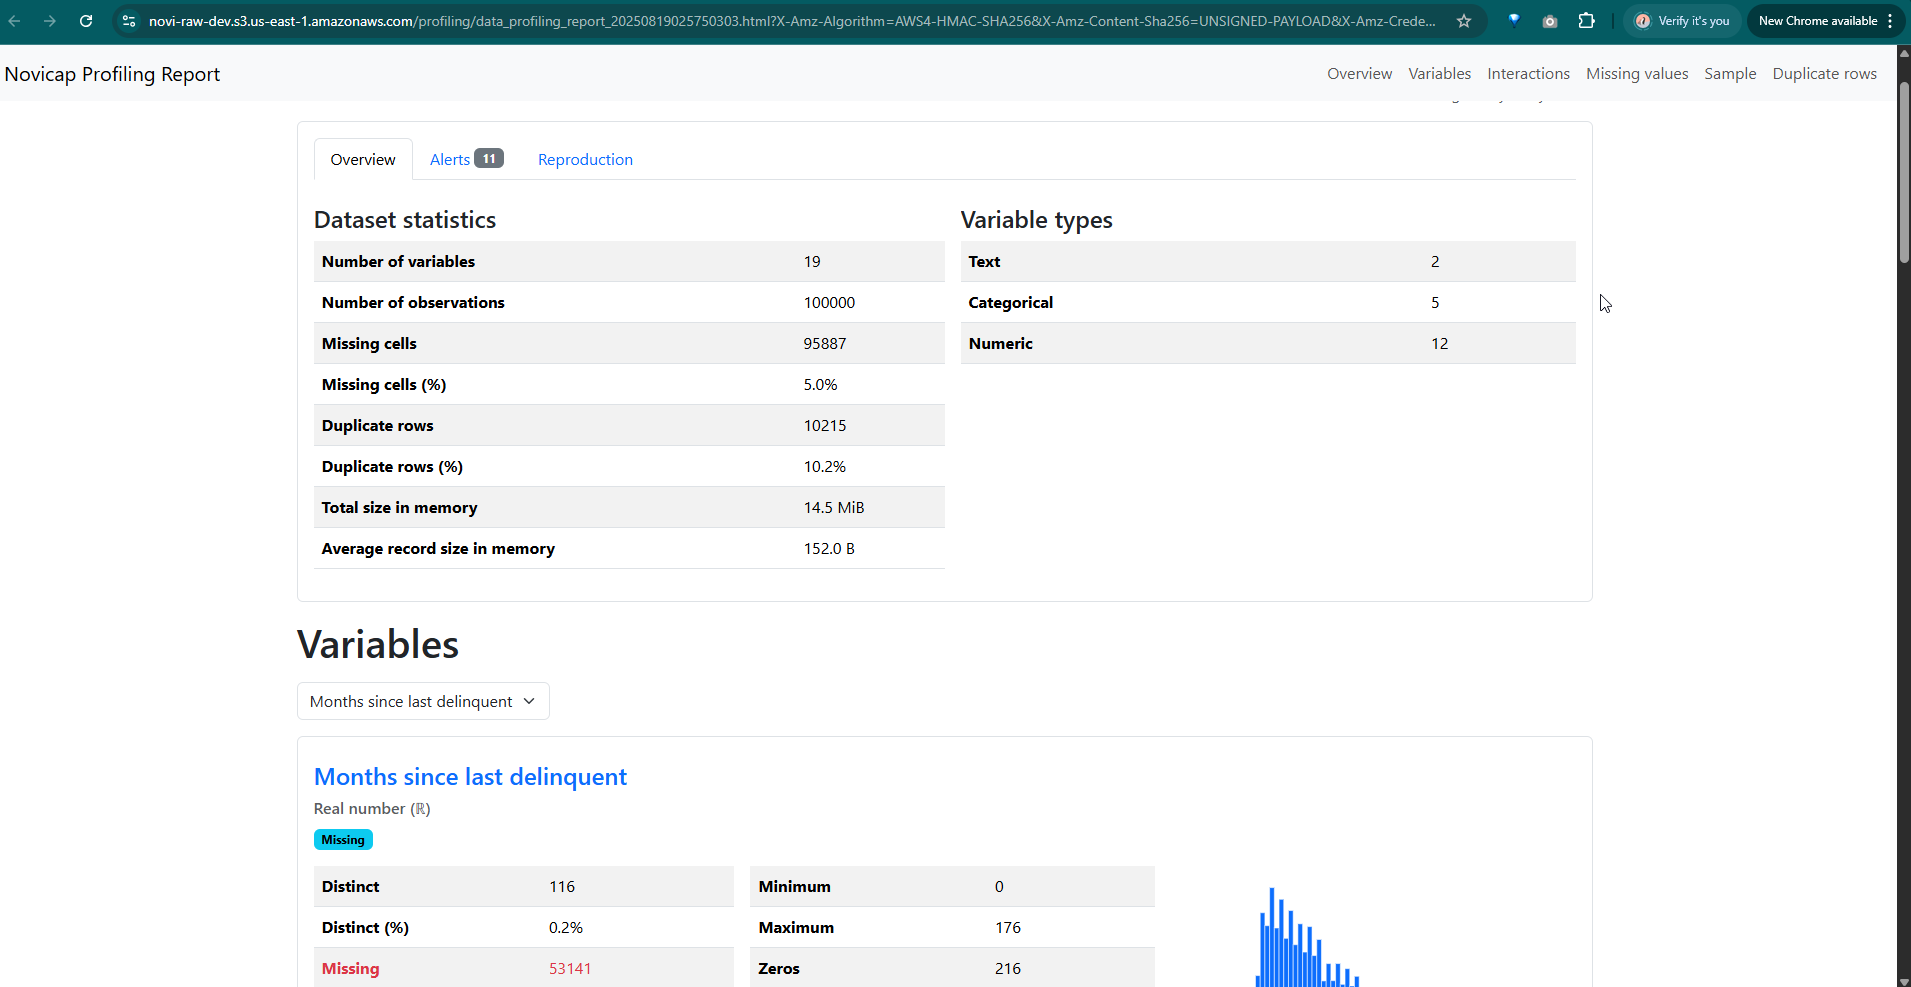

Author: @svargasg [Sebastian Vargas Gantiva]

<div align="left">
    <a href="../README.md"><< README </a>
</div>

<div align="right">
    <a href="../docs/Data Ingestion.md">Data Ingestion >></a>
</div>